# Start Code

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
import h5py
import numpy as np
import os
import cv2
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.preprocessing import StandardScaler
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc,roc_curve
from matplotlib import pyplot as plt

In [ ]:
x_dataset=[]
y_dataset=[]
src=os.listdir('/content/gdrive/MyDrive/Breast MRI Data Analysis/Healthy')
i=0
for filename in src:
    full_file_name='/content/gdrive/MyDrive/Breast MRI Data Analysis/Healthy/'+filename
    x=cv2.imread(full_file_name)
    x=np.array(x,dtype='float32')
    y=1
    y=np.array(y,dtype='float32')
    x=x/255.0
    x=cv2.resize(x,(224,224))
    x_dataset.append(x)
    y_dataset.append(y)
    i=i+1


In [ ]:

src=os.listdir('/content/gdrive/MyDrive/Breast MRI Data Analysis/Sick')
for filename in src:
    full_file_name='/content/gdrive/MyDrive/Breast MRI Data Analysis/Sick/'+filename
    x=cv2.imread(full_file_name)
    x=np.array(x,dtype='float32')
    y=0
    y=np.array(y,dtype='float32')
    x=x/255.0
    x=cv2.resize(x,(224,224))
    x_dataset.append(x)
    y_dataset.append(y)
    i=i+1

In [ ]:
X_dataset=np.array(x_dataset)
Y_dataset=np.array(y_dataset)
Y_dataset=Y_dataset.reshape((1480,1))

In [ ]:
from sklearn.utils import shuffle
X_dataset,Y_dataset=shuffle(X_dataset,Y_dataset,random_state=0)

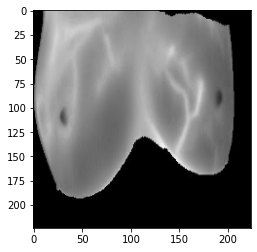

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_dataset[60])
plt.show()

In [ ]:
Healthy_len=0
Sick_len=0
for i in range(1480):
    if Y_dataset[i]==0:
        Sick_len+=1
    else:
        Healthy_len+=1
print(Healthy_len)
print(Sick_len)

740
740


<Axes: >

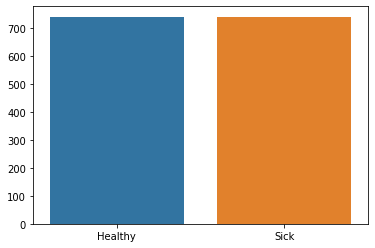

In [ ]:

import seaborn as sns
sns.barplot(x=['Healthy','Sick'],y=[Healthy_len,Sick_len])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_dataset,Y_dataset,test_size=0.10,shuffle=False)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
folds=list(StratifiedShuffleSplit(n_splits=2,random_state=0,test_size=0.15).split(x_train,y_train))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(  rotation_range=8,
                                     width_shift_range=0.03,
                                     height_shift_range=0.03,
                                     shear_range=0.25,
                                     zoom_range=0.45,
                                     horizontal_flip=True)
val_datagen = ImageDataGenerator(zoom_range=0.45)

# InceptionV3

In [ ]:
base_model1 = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model1.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x1 = base_model1(inputs, training=False)
x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)
x1 = tf.keras.layers.Dense(1)(x1)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x1)
model1 = tf.keras.Model(inputs, outputs)
model1.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
 activation_94 (Activation)  (None, 1)                 0      

In [ ]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h51'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model1.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict1_1=model1.predict(x_val)
    Y_predict1_1=np.float32(y_predict1_1>0.50)
    l=len(y_val)
    Y_predict1_1=np.reshape(Y_predict1_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7386 - accuracy: 0.5415 - auc: 0.5495 - precision: 0.5463 - recall: 0.5833
Epoch 1: val_accuracy improved from -inf to 0.64000, saving model to best_model.h51


36/36 [==============================] - 66s 1s/step - loss: 0.7386 - accuracy: 0.5415 - auc: 0.5495 - precision: 0.5463 - recall: 0.5833 - val_loss: 0.6235 - val_accuracy: 0.6400 - val_auc: 0.7097 - val_precision: 0.5941 - val_recall: 0.6593
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.6042 - auc: 0.6596 - precision: 0.6135 - recall: 0.6007
Epoch 2: val_accuracy did not improve from 0.64000
36/36 [==============================] - 13s 365ms/step - loss: 0.6643 - accuracy: 0.6042 - auc: 0.6596 - precision: 0.6135 - recall: 0.6007 - val_loss: 0.6743 - val_accuracy: 0.5900 - val_auc: 0.7581 - val_precision: 0.5273 - val_recall: 0.9560
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.6528 - auc: 0.7023 - precision: 0.6459 - recall: 0.7031
Epoch 3: val_accuracy improved from 0.64000 to 0.73000, saving model to best_model.h51


36/36 [==============================] - 47s 1s/step - loss: 0.6312 - accuracy: 0.6528 - auc: 0.7023 - precision: 0.6459 - recall: 0.7031 - val_loss: 0.5667 - val_accuracy: 0.7300 - val_auc: 0.7813 - val_precision: 0.6697 - val_recall: 0.8022
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.6484 - auc: 0.7075 - precision: 0.6529 - recall: 0.6597
Epoch 4: val_accuracy did not improve from 0.73000
36/36 [==============================] - 13s 367ms/step - loss: 0.6256 - accuracy: 0.6484 - auc: 0.7075 - precision: 0.6529 - recall: 0.6597 - val_loss: 0.5574 - val_accuracy: 0.6900 - val_auc: 0.7955 - val_precision: 0.7164 - val_recall: 0.5275
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.6405 - auc: 0.6969 - precision: 0.6459 - recall: 0.6493
Epoch 5: val_accuracy did not improve from 0.73000
36/36 [==============================] - 13s 374ms/step - loss: 0.6384 - accuracy: 0.6405 - auc: 0.6969 - precision: 0.

36/36 [==============================] - 48s 1s/step - loss: 0.5402 - accuracy: 0.7288 - auc: 0.8006 - precision: 0.7245 - recall: 0.7535 - val_loss: 0.5185 - val_accuracy: 0.7350 - val_auc: 0.8239 - val_precision: 0.6759 - val_recall: 0.8022
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.7253 - auc: 0.8002 - precision: 0.7320 - recall: 0.7257
Epoch 10: val_accuracy did not improve from 0.73500
7/7 [==============================] - 2s 76ms/step
Fold 2
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.6988 - auc: 0.7748 - precision: 0.6984 - recall: 0.6922
Epoch 1: val_accuracy improved from 0.73500 to 0.77500, saving model to best_model.h51


36/36 [==============================] - 48s 1s/step - loss: 0.5674 - accuracy: 0.6988 - auc: 0.7748 - precision: 0.6984 - recall: 0.6922 - val_loss: 0.4473 - val_accuracy: 0.7750 - val_auc: 0.9000 - val_precision: 0.8488 - val_recall: 0.6952
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.5318 - accuracy: 0.7367 - auc: 0.8119 - precision: 0.7292 - recall: 0.7473
Epoch 2: val_accuracy did not improve from 0.77500
36/36 [==============================] - 13s 380ms/step - loss: 0.5318 - accuracy: 0.7367 - auc: 0.8119 - precision: 0.7292 - recall: 0.7473 - val_loss: 0.4497 - val_accuracy: 0.7750 - val_auc: 0.9014 - val_precision: 0.8571 - val_recall: 0.6857
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.7226 - auc: 0.8014 - precision: 0.7183 - recall: 0.7260
Epoch 3: val_accuracy improved from 0.77500 to 0.82000, saving model to best_model.h51


36/36 [==============================] - 48s 1s/step - loss: 0.5409 - accuracy: 0.7226 - auc: 0.8014 - precision: 0.7183 - recall: 0.7260 - val_loss: 0.4250 - val_accuracy: 0.8200 - val_auc: 0.9054 - val_precision: 0.7949 - val_recall: 0.8857
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.5538 - accuracy: 0.7111 - auc: 0.7909 - precision: 0.6936 - recall: 0.7491
Epoch 4: val_accuracy did not improve from 0.82000
36/36 [==============================] - 13s 364ms/step - loss: 0.5538 - accuracy: 0.7111 - auc: 0.7909 - precision: 0.6936 - recall: 0.7491 - val_loss: 0.4386 - val_accuracy: 0.8000 - val_auc: 0.9015 - val_precision: 0.8652 - val_recall: 0.7333
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.7173 - auc: 0.7965 - precision: 0.7274 - recall: 0.6886
Epoch 5: val_accuracy did not improve from 0.82000
36/36 [==============================] - 13s 372ms/step - loss: 0.5523 - accuracy: 0.7173 - auc: 0.7965 - precision: 0.

In [ ]:
model1.evaluate(train_datagen.flow(x_train,y_train))
model1.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 274ms/step - loss: 0.4473 - accuracy: 0.7900 - auc: 0.8853 - precision: 0.8182 - recall: 0.7714


[0.4473213851451874,
 0.7900000214576721,
 0.8853132724761963,
 0.8181818127632141,
 0.7714285850524902]

In [ ]:
y_predict1_2=model1.predict(x_test)
Y_predict1_2=np.float32(y_predict1_2>0.50)
l=len(y_test)
Y_predict1_2=np.reshape(Y_predict1_2,(l,1))
print(Y_predict1_2)

5/5 [==============================] - 1s 319ms/step
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f11 = f1_score(y_test, Y_predict1_2)
test_accuracy1 = accuracy_score(y_test, Y_predict1_2)
kappa1 = cohen_kappa_score(y_test, Y_predict1_2)
auc1 = roc_auc_score(y_test, Y_predict1_2)

In [ ]:
print(auc1)
print(f11)
print(kappa1)
print(test_accuracy1)

0.7824456114028507
0.8095238095238095
0.5598513011152417
0.7837837837837838


# VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
base_model2 = VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model2.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x2 = base_model2(inputs, training=False)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)
x2 = tf.keras.layers.Dense(1)(x2)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x2)
model2 = tf.keras.Model(inputs, outputs)
model2.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
 activation_95 (Activation)  (None, 1)                 0    

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h52'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history2=model2.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict2_1=model2.predict(x_val)
    Y_predict2_1=np.float32(y_predict2_1>0.50)
    l=len(y_val)
    Y_predict2_1=np.reshape(Y_predict2_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7001 - accuracy: 0.5239 - auc: 0.5203 - precision: 0.5311 - recall: 0.5486
Epoch 1: val_accuracy improved from -inf to 0.57500, saving model to best_model.h52


36/36 [==============================] - 23s 543ms/step - loss: 0.7001 - accuracy: 0.5239 - auc: 0.5203 - precision: 0.5311 - recall: 0.5486 - val_loss: 0.6892 - val_accuracy: 0.5750 - val_auc: 0.6456 - val_precision: 0.5174 - val_recall: 0.9780
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5194 - auc: 0.5399 - precision: 0.5253 - recall: 0.5764
Epoch 2: val_accuracy improved from 0.57500 to 0.62000, saving model to best_model.h52


36/36 [==============================] - 19s 527ms/step - loss: 0.6935 - accuracy: 0.5194 - auc: 0.5399 - precision: 0.5253 - recall: 0.5764 - val_loss: 0.6819 - val_accuracy: 0.6200 - val_auc: 0.6630 - val_precision: 0.5484 - val_recall: 0.9341
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5283 - auc: 0.5426 - precision: 0.5317 - recall: 0.6111
Epoch 3: val_accuracy improved from 0.62000 to 0.65000, saving model to best_model.h52


36/36 [==============================] - 16s 452ms/step - loss: 0.6932 - accuracy: 0.5283 - auc: 0.5426 - precision: 0.5317 - recall: 0.6111 - val_loss: 0.6705 - val_accuracy: 0.6500 - val_auc: 0.6804 - val_precision: 0.5868 - val_recall: 0.7802
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.5398 - auc: 0.5577 - precision: 0.5444 - recall: 0.5851
Epoch 4: val_accuracy improved from 0.65000 to 0.66500, saving model to best_model.h52


36/36 [==============================] - 17s 471ms/step - loss: 0.6892 - accuracy: 0.5398 - auc: 0.5577 - precision: 0.5444 - recall: 0.5851 - val_loss: 0.6683 - val_accuracy: 0.6650 - val_auc: 0.6941 - val_precision: 0.5952 - val_recall: 0.8242
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.5601 - auc: 0.5944 - precision: 0.5753 - recall: 0.5174
Epoch 5: val_accuracy did not improve from 0.66500
36/36 [==============================] - 14s 385ms/step - loss: 0.6783 - accuracy: 0.5601 - auc: 0.5944 - precision: 0.5753 - recall: 0.5174 - val_loss: 0.6728 - val_accuracy: 0.6450 - val_auc: 0.7049 - val_precision: 0.5667 - val_recall: 0.9341
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.5760 - auc: 0.6205 - precision: 0.5594 - recall: 0.7847
Epoch 6: val_accuracy did not improve from 0.66500
36/36 [==============================] - 14s 386ms/step - loss: 0.6753 - accuracy: 0.5760 - auc: 0.6205 - precision:

36/36 [==============================] - 17s 483ms/step - loss: 0.6801 - accuracy: 0.5565 - auc: 0.5871 - precision: 0.5529 - recall: 0.6719 - val_loss: 0.6572 - val_accuracy: 0.6700 - val_auc: 0.7229 - val_precision: 0.5984 - val_recall: 0.8352
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.5857 - auc: 0.6160 - precision: 0.5911 - recall: 0.6024
Epoch 9: val_accuracy did not improve from 0.67000
36/36 [==============================] - 14s 375ms/step - loss: 0.6740 - accuracy: 0.5857 - auc: 0.6160 - precision: 0.5911 - recall: 0.6024 - val_loss: 0.6523 - val_accuracy: 0.6700 - val_auc: 0.7293 - val_precision: 0.6000 - val_recall: 0.8242
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.6684 - accuracy: 0.6042 - auc: 0.6362 - precision: 0.6016 - recall: 0.6580
Epoch 10: val_accuracy did not improve from 0.67000
7/7 [==============================] - 1s 128ms/step
Fold 2
Epoch 1/10
36/36 [==============================] - ET

36/36 [==============================] - 17s 458ms/step - loss: 0.6576 - accuracy: 0.6201 - auc: 0.6707 - precision: 0.6410 - recall: 0.5338 - val_loss: 0.6352 - val_accuracy: 0.6800 - val_auc: 0.7370 - val_precision: 0.6881 - val_recall: 0.7143
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.6078 - auc: 0.6614 - precision: 0.6077 - recall: 0.5925
Epoch 6: val_accuracy improved from 0.68000 to 0.70000, saving model to best_model.h52


36/36 [==============================] - 18s 490ms/step - loss: 0.6563 - accuracy: 0.6078 - auc: 0.6614 - precision: 0.6077 - recall: 0.5925 - val_loss: 0.6329 - val_accuracy: 0.7000 - val_auc: 0.7417 - val_precision: 0.6860 - val_recall: 0.7905
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.6201 - auc: 0.6668 - precision: 0.6170 - recall: 0.6192
Epoch 7: val_accuracy did not improve from 0.70000
36/36 [==============================] - 14s 382ms/step - loss: 0.6533 - accuracy: 0.6201 - auc: 0.6668 - precision: 0.6170 - recall: 0.6192 - val_loss: 0.6311 - val_accuracy: 0.6850 - val_auc: 0.7408 - val_precision: 0.6909 - val_recall: 0.7238
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.6334 - auc: 0.6800 - precision: 0.6227 - recall: 0.6637
Epoch 8: val_accuracy did not improve from 0.70000
36/36 [==============================] - 14s 378ms/step - loss: 0.6496 - accuracy: 0.6334 - auc: 0.6800 - precision:

In [ ]:
model2.evaluate(train_datagen.flow(x_train,y_train))
model2.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 3s 315ms/step - loss: 0.6389 - accuracy: 0.6650 - auc: 0.7294 - precision: 0.7159 - recall: 0.6000


[0.6389079093933105,
 0.6650000214576721,
 0.7294235229492188,
 0.7159090638160706,
 0.6000000238418579]

In [ ]:
y_predict2_2=model2.predict(x_test)
Y_predict2_2=np.float32(y_predict2_2>0.50)
l=len(y_test)
Y_predict2_2=np.reshape(Y_predict2_2,(l,1))
print(Y_predict2_2)

5/5 [==============================] - 3s 661ms/step
[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f12 = f1_score(y_test, Y_predict2_2)
test_accuracy2 = accuracy_score(y_test, Y_predict2_2)
kappa2 = cohen_kappa_score(y_test, Y_predict2_2)
auc2 = roc_auc_score(y_test, Y_predict2_2)

In [ ]:
print(auc2)
print(f12)
print(kappa2)
print(test_accuracy2)

0.650787696924231
0.7126436781609196
0.3029389600602863
0.6621621621621622


# VGG19

In [ ]:
from keras.applications.vgg19 import VGG19
base_model3 = VGG19(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model3.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x3 = base_model3(inputs, training=False)
x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
x3 = tf.keras.layers.Dropout(0.2)(x3)
x3 = tf.keras.layers.Dense(1)(x3)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x3)
model3 = tf.keras.Model(inputs, outputs)
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
 activation_96 (Activation)  (None, 1)                 0         
                                                           

In [ ]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h53'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history3=model3.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict3_1=model3.predict(x_val)
    Y_predict3_1=np.float32(y_predict3_1>0.50)
    l=len(y_val)
    Y_predict3_1=np.reshape(Y_predict3_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7144 - accuracy: 0.4682 - auc: 0.4577 - precision: 0.4803 - recall: 0.5503
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to best_model.h53


36/36 [==============================] - 19s 495ms/step - loss: 0.7144 - accuracy: 0.4682 - auc: 0.4577 - precision: 0.4803 - recall: 0.5503 - val_loss: 0.6973 - val_accuracy: 0.4500 - val_auc: 0.5625 - val_precision: 0.4508 - val_recall: 0.9560
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.5027 - auc: 0.5093 - precision: 0.5104 - recall: 0.5538
Epoch 2: val_accuracy improved from 0.45000 to 0.59000, saving model to best_model.h53


36/36 [==============================] - 19s 524ms/step - loss: 0.7014 - accuracy: 0.5027 - auc: 0.5093 - precision: 0.5104 - recall: 0.5538 - val_loss: 0.6860 - val_accuracy: 0.5900 - val_auc: 0.6384 - val_precision: 0.5372 - val_recall: 0.7143
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5371 - auc: 0.5447 - precision: 0.5455 - recall: 0.5417
Epoch 3: val_accuracy improved from 0.59000 to 0.60000, saving model to best_model.h53


36/36 [==============================] - 17s 482ms/step - loss: 0.6921 - accuracy: 0.5371 - auc: 0.5447 - precision: 0.5455 - recall: 0.5417 - val_loss: 0.6840 - val_accuracy: 0.6000 - val_auc: 0.6643 - val_precision: 0.5401 - val_recall: 0.8132
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.5327 - auc: 0.5330 - precision: 0.5380 - recall: 0.5781
Epoch 4: val_accuracy did not improve from 0.60000
36/36 [==============================] - 15s 404ms/step - loss: 0.6953 - accuracy: 0.5327 - auc: 0.5330 - precision: 0.5380 - recall: 0.5781 - val_loss: 0.6923 - val_accuracy: 0.4500 - val_auc: 0.6717 - val_precision: 0.4518 - val_recall: 0.9780
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5504 - auc: 0.5715 - precision: 0.5519 - recall: 0.6181
Epoch 5: val_accuracy improved from 0.60000 to 0.62500, saving model to best_model.h53


36/36 [==============================] - 18s 495ms/step - loss: 0.6855 - accuracy: 0.5504 - auc: 0.5715 - precision: 0.5519 - recall: 0.6181 - val_loss: 0.6690 - val_accuracy: 0.6250 - val_auc: 0.6874 - val_precision: 0.6333 - val_recall: 0.4176
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5618 - auc: 0.5895 - precision: 0.5816 - recall: 0.4948
Epoch 6: val_accuracy did not improve from 0.62500
36/36 [==============================] - 15s 401ms/step - loss: 0.6805 - accuracy: 0.5618 - auc: 0.5895 - precision: 0.5816 - recall: 0.4948 - val_loss: 0.6767 - val_accuracy: 0.6250 - val_auc: 0.6885 - val_precision: 0.5571 - val_recall: 0.8571
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.5724 - auc: 0.5939 - precision: 0.5685 - recall: 0.6632
Epoch 7: val_accuracy improved from 0.62500 to 0.63000, saving model to best_model.h53


36/36 [==============================] - 17s 484ms/step - loss: 0.6811 - accuracy: 0.5724 - auc: 0.5939 - precision: 0.5685 - recall: 0.6632 - val_loss: 0.6725 - val_accuracy: 0.6300 - val_auc: 0.6946 - val_precision: 0.5639 - val_recall: 0.8242
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.5786 - auc: 0.5981 - precision: 0.5716 - recall: 0.6858
Epoch 8: val_accuracy improved from 0.63000 to 0.65500, saving model to best_model.h53


36/36 [==============================] - 18s 507ms/step - loss: 0.6788 - accuracy: 0.5786 - auc: 0.5981 - precision: 0.5716 - recall: 0.6858 - val_loss: 0.6654 - val_accuracy: 0.6550 - val_auc: 0.6990 - val_precision: 0.5917 - val_recall: 0.7802
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.5707 - auc: 0.6021 - precision: 0.5748 - recall: 0.6007
Epoch 9: val_accuracy did not improve from 0.65500
36/36 [==============================] - 14s 391ms/step - loss: 0.6763 - accuracy: 0.5707 - auc: 0.6021 - precision: 0.5748 - recall: 0.6007 - val_loss: 0.6690 - val_accuracy: 0.6400 - val_auc: 0.7013 - val_precision: 0.5704 - val_recall: 0.8462
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.5733 - auc: 0.6008 - precision: 0.5703 - recall: 0.6545
Epoch 10: val_accuracy improved from 0.65500 to 0.66000, saving model to best_model.h53


7/7 [==============================] - 1s 157ms/step
Fold 2
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.5954 - auc: 0.6378 - precision: 0.5959 - recall: 0.5747
Epoch 1: val_accuracy improved from 0.66000 to 0.67500, saving model to best_model.h53


36/36 [==============================] - 18s 491ms/step - loss: 0.6668 - accuracy: 0.5954 - auc: 0.6378 - precision: 0.5959 - recall: 0.5747 - val_loss: 0.6531 - val_accuracy: 0.6750 - val_auc: 0.7018 - val_precision: 0.6754 - val_recall: 0.7333
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.6007 - auc: 0.6391 - precision: 0.6127 - recall: 0.5320
Epoch 2: val_accuracy improved from 0.67500 to 0.68000, saving model to best_model.h53


36/36 [==============================] - 18s 509ms/step - loss: 0.6689 - accuracy: 0.6007 - auc: 0.6391 - precision: 0.6127 - recall: 0.5320 - val_loss: 0.6538 - val_accuracy: 0.6800 - val_auc: 0.7041 - val_precision: 0.7303 - val_recall: 0.6190
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.5786 - auc: 0.6025 - precision: 0.5758 - recall: 0.5747
Epoch 3: val_accuracy did not improve from 0.68000
36/36 [==============================] - 14s 398ms/step - loss: 0.6770 - accuracy: 0.5786 - auc: 0.6025 - precision: 0.5758 - recall: 0.5747 - val_loss: 0.6526 - val_accuracy: 0.6500 - val_auc: 0.7091 - val_precision: 0.7011 - val_recall: 0.5810
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.6157 - auc: 0.6508 - precision: 0.6112 - recall: 0.6210
Epoch 4: val_accuracy improved from 0.68000 to 0.70500, saving model to best_model.h53


36/36 [==============================] - 18s 508ms/step - loss: 0.6651 - accuracy: 0.6157 - auc: 0.6508 - precision: 0.6112 - recall: 0.6210 - val_loss: 0.6491 - val_accuracy: 0.7050 - val_auc: 0.7096 - val_precision: 0.7300 - val_recall: 0.6952
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.6184 - auc: 0.6479 - precision: 0.6208 - recall: 0.5943
Epoch 5: val_accuracy did not improve from 0.70500
36/36 [==============================] - 14s 389ms/step - loss: 0.6648 - accuracy: 0.6184 - auc: 0.6479 - precision: 0.6208 - recall: 0.5943 - val_loss: 0.6495 - val_accuracy: 0.6300 - val_auc: 0.7113 - val_precision: 0.6867 - val_recall: 0.5429
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.6184 - auc: 0.6346 - precision: 0.6337 - recall: 0.5480
Epoch 6: val_accuracy did not improve from 0.70500
36/36 [==============================] - 15s 403ms/step - loss: 0.6685 - accuracy: 0.6184 - auc: 0.6346 - precision:

In [ ]:
model3.evaluate(train_datagen.flow(x_train,y_train))
model3.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 295ms/step - loss: 0.6477 - accuracy: 0.6900 - auc: 0.7220 - precision: 0.7172 - recall: 0.6762


[0.6476667523384094,
 0.6899999976158142,
 0.7220050096511841,
 0.7171717286109924,
 0.6761904954910278]

In [ ]:
y_predict3_2=model3.predict(x_test)
Y_predict3_2=np.float32(y_predict3_2>0.50)
l=len(y_test)
Y_predict3_2=np.reshape(Y_predict3_2,(l,1))
print(Y_predict3_2)

5/5 [==============================] - 1s 148ms/step
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f13 = f1_score(y_test, Y_predict3_2)
test_accuracy3 = accuracy_score(y_test, Y_predict3_2)
kappa3 = cohen_kappa_score(y_test, Y_predict3_2)
auc3 = roc_auc_score(y_test, Y_predict3_2)

In [ ]:
print(auc3)
print(f13)
print(kappa3)
print(test_accuracy3)

0.6856714178544636
0.7555555555555555
0.37815126050420167
0.7027027027027027


# InceptionResNetV2

In [ ]:
base_model4 = tf.keras.applications.InceptionResNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model4.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x4 = base_model4(inputs, training=False)
x4 = tf.keras.layers.GlobalAveragePooling2D()(x4)
x4 = tf.keras.layers.Dropout(0.2)(x4)
x4 = tf.keras.layers.Dense(1)(x4)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x4)
model4 = tf.keras.Model(inputs, outputs)
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
 activation_203 (Activation)  (None, 1)                0     

In [ ]:
model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h54'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model4.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict4_1=model4.predict(x_val)
    Y_predict4_1=np.float32(y_predict4_1>0.50)
    l=len(y_val)
    Y_predict4_1=np.reshape(Y_predict4_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7662 - accuracy: 0.5327 - auc: 0.5353 - precision: 0.5325 - recall: 0.5485
Epoch 1: val_accuracy improved from -inf to 0.63000, saving model to best_model.h54


36/36 [==============================] - 121s 3s/step - loss: 0.7662 - accuracy: 0.5327 - auc: 0.5353 - precision: 0.5325 - recall: 0.5485 - val_loss: 0.6245 - val_accuracy: 0.6300 - val_auc: 0.7118 - val_precision: 0.6083 - val_recall: 0.7300
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.5892 - auc: 0.6315 - precision: 0.5927 - recall: 0.5750
Epoch 2: val_accuracy did not improve from 0.63000
36/36 [==============================] - 15s 403ms/step - loss: 0.7021 - accuracy: 0.5892 - auc: 0.6315 - precision: 0.5927 - recall: 0.5750 - val_loss: 0.6552 - val_accuracy: 0.6150 - val_auc: 0.7699 - val_precision: 0.5732 - val_recall: 0.9000
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.6051 - auc: 0.6496 - precision: 0.6007 - recall: 0.6314
Epoch 3: val_accuracy improved from 0.63000 to 0.70500, saving model to best_model.h54


36/36 [==============================] - 96s 3s/step - loss: 0.6837 - accuracy: 0.6051 - auc: 0.6496 - precision: 0.6007 - recall: 0.6314 - val_loss: 0.5711 - val_accuracy: 0.7050 - val_auc: 0.7772 - val_precision: 0.7303 - val_recall: 0.6500
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.6007 - auc: 0.6553 - precision: 0.6095 - recall: 0.5644
Epoch 4: val_accuracy improved from 0.70500 to 0.72500, saving model to best_model.h54


36/36 [==============================] - 97s 3s/step - loss: 0.6826 - accuracy: 0.6007 - auc: 0.6553 - precision: 0.6095 - recall: 0.5644 - val_loss: 0.5613 - val_accuracy: 0.7250 - val_auc: 0.8029 - val_precision: 0.6800 - val_recall: 0.8500
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6497 - accuracy: 0.6343 - auc: 0.6810 - precision: 0.6340 - recall: 0.6384
Epoch 5: val_accuracy did not improve from 0.72500
36/36 [==============================] - 15s 409ms/step - loss: 0.6497 - accuracy: 0.6343 - auc: 0.6810 - precision: 0.6340 - recall: 0.6384 - val_loss: 0.5745 - val_accuracy: 0.7100 - val_auc: 0.8142 - val_precision: 0.6544 - val_recall: 0.8900
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6267 - accuracy: 0.6608 - auc: 0.7153 - precision: 0.6591 - recall: 0.6684
Epoch 6: val_accuracy improved from 0.72500 to 0.73500, saving model to best_model.h54


36/36 [==============================] - 98s 3s/step - loss: 0.6267 - accuracy: 0.6608 - auc: 0.7153 - precision: 0.6591 - recall: 0.6684 - val_loss: 0.5348 - val_accuracy: 0.7350 - val_auc: 0.8177 - val_precision: 0.7043 - val_recall: 0.8100
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.6634 - auc: 0.7213 - precision: 0.6667 - recall: 0.6561
Epoch 7: val_accuracy did not improve from 0.73500
36/36 [==============================] - 15s 408ms/step - loss: 0.6171 - accuracy: 0.6634 - auc: 0.7213 - precision: 0.6667 - recall: 0.6561 - val_loss: 0.5731 - val_accuracy: 0.7050 - val_auc: 0.8256 - val_precision: 0.6454 - val_recall: 0.9100
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.6714 - auc: 0.7393 - precision: 0.6644 - recall: 0.6949
Epoch 8: val_accuracy improved from 0.73500 to 0.75500, saving model to best_model.h54


36/36 [==============================] - 97s 3s/step - loss: 0.5991 - accuracy: 0.6714 - auc: 0.7393 - precision: 0.6644 - recall: 0.6949 - val_loss: 0.5133 - val_accuracy: 0.7550 - val_auc: 0.8335 - val_precision: 0.7339 - val_recall: 0.8000
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.6511 - auc: 0.7312 - precision: 0.6519 - recall: 0.6508
Epoch 9: val_accuracy improved from 0.75500 to 0.76500, saving model to best_model.h54


36/36 [==============================] - 96s 3s/step - loss: 0.6092 - accuracy: 0.6511 - auc: 0.7312 - precision: 0.6519 - recall: 0.6508 - val_loss: 0.5129 - val_accuracy: 0.7650 - val_auc: 0.8339 - val_precision: 0.7732 - val_recall: 0.7500
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.6996 - auc: 0.7713 - precision: 0.6947 - recall: 0.7143
Epoch 10: val_accuracy did not improve from 0.76500
7/7 [==============================] - 5s 178ms/step
Fold 2
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.6837 - auc: 0.7632 - precision: 0.6835 - recall: 0.6762
Epoch 1: val_accuracy improved from 0.76500 to 0.79000, saving model to best_model.h54


36/36 [==============================] - 97s 3s/step - loss: 0.5786 - accuracy: 0.6837 - auc: 0.7632 - precision: 0.6835 - recall: 0.6762 - val_loss: 0.4826 - val_accuracy: 0.7900 - val_auc: 0.8622 - val_precision: 0.7890 - val_recall: 0.8190
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.5601 - accuracy: 0.6970 - auc: 0.7785 - precision: 0.6885 - recall: 0.7117
Epoch 2: val_accuracy did not improve from 0.79000
36/36 [==============================] - 15s 409ms/step - loss: 0.5601 - accuracy: 0.6970 - auc: 0.7785 - precision: 0.6885 - recall: 0.7117 - val_loss: 0.4750 - val_accuracy: 0.7800 - val_auc: 0.8642 - val_precision: 0.7748 - val_recall: 0.8190
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.7032 - auc: 0.7816 - precision: 0.6989 - recall: 0.7064
Epoch 3: val_accuracy did not improve from 0.79000
36/36 [==============================] - 15s 414ms/step - loss: 0.5591 - accuracy: 0.7032 - auc: 0.7816 - precision: 0.

36/36 [==============================] - 97s 3s/step - loss: 0.5453 - accuracy: 0.7200 - auc: 0.7966 - precision: 0.7087 - recall: 0.7402 - val_loss: 0.4634 - val_accuracy: 0.7950 - val_auc: 0.8782 - val_precision: 0.8200 - val_recall: 0.7810
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7244 - auc: 0.7967 - precision: 0.7201 - recall: 0.7278
Epoch 8: val_accuracy improved from 0.79500 to 0.80000, saving model to best_model.h54


36/36 [==============================] - 98s 3s/step - loss: 0.5437 - accuracy: 0.7244 - auc: 0.7967 - precision: 0.7201 - recall: 0.7278 - val_loss: 0.4635 - val_accuracy: 0.8000 - val_auc: 0.8851 - val_precision: 0.8351 - val_recall: 0.7714
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.7226 - auc: 0.8043 - precision: 0.7102 - recall: 0.7456
Epoch 9: val_accuracy improved from 0.80000 to 0.82000, saving model to best_model.h54


36/36 [==============================] - 97s 3s/step - loss: 0.5382 - accuracy: 0.7226 - auc: 0.8043 - precision: 0.7102 - recall: 0.7456 - val_loss: 0.4490 - val_accuracy: 0.8200 - val_auc: 0.8870 - val_precision: 0.8165 - val_recall: 0.8476
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.5345 - accuracy: 0.7155 - auc: 0.8021 - precision: 0.7098 - recall: 0.7224
Epoch 10: val_accuracy did not improve from 0.82000
7/7 [==============================] - 1s 156ms/step


In [ ]:
model4.evaluate(train_datagen.flow(x_train,y_train))
model4.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 302ms/step - loss: 0.5165 - accuracy: 0.7450 - auc: 0.8167 - precision: 0.7177 - recall: 0.8476


[0.5164514183998108,
 0.7450000047683716,
 0.8166917562484741,
 0.7177419066429138,
 0.8476190567016602]

In [ ]:
y_predict4_1=model4.predict(x_test)
Y_predict4_1=np.float32(y_predict4_1>0.50)
l=len(y_test)
Y_predict4_1=np.reshape(Y_predict4_1,(l,1))
print(Y_predict4_1)

5/5 [==============================] - 2s 423ms/step
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f14 = f1_score(y_test, Y_predict4_1)
test_accuracy4 = accuracy_score(y_test, Y_predict4_1)
kappa4 = cohen_kappa_score(y_test, Y_predict4_1)
auc4 = roc_auc_score(y_test, Y_predict4_1)

In [ ]:
print(auc4)
print(f14)
print(kappa4)
print(test_accuracy4)

0.8148558758314856
0.8505747126436782
0.6391597899474868
0.8243243243243243


# MobileNet

In [ ]:
from keras.applications import MobileNet
base_model5 = tf.keras.applications.mobilenet.MobileNet(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model5.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x5 = base_model5(inputs, training=False)
x5 = tf.keras.layers.GlobalAveragePooling2D()(x5)
x5 = tf.keras.layers.Dropout(0.2)(x5)
x5 = tf.keras.layers.Dense(1)(x5)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x5)
model5 = tf.keras.Model(inputs, outputs)
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
 activation (Activation)     (None, 1)                 0     

In [ ]:
model5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h55'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model5.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict5_1=model5.predict(x_val)
    Y_predict5_1=np.float32(y_predict5_1>0.50)
    l=len(y_val)
    Y_predict5_1=np.reshape(Y_predict5_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7472 - accuracy: 0.5459 - auc: 0.5779 - precision: 0.5497 - recall: 0.5612
Epoch 1: val_accuracy improved from -inf to 0.60500, saving model to best_model.h55


36/36 [==============================] - 38s 699ms/step - loss: 0.7472 - accuracy: 0.5459 - auc: 0.5779 - precision: 0.5497 - recall: 0.5612 - val_loss: 0.6986 - val_accuracy: 0.6050 - val_auc: 0.6099 - val_precision: 0.5645 - val_recall: 0.7368
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.5839 - auc: 0.6396 - precision: 0.5913 - recall: 0.5717
Epoch 2: val_accuracy improved from 0.60500 to 0.65500, saving model to best_model.h55


36/36 [==============================] - 26s 728ms/step - loss: 0.6813 - accuracy: 0.5839 - auc: 0.6396 - precision: 0.5913 - recall: 0.5717 - val_loss: 0.6631 - val_accuracy: 0.6550 - val_auc: 0.6726 - val_precision: 0.6048 - val_recall: 0.7895
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.6572 - auc: 0.7166 - precision: 0.6554 - recall: 0.6783
Epoch 3: val_accuracy improved from 0.65500 to 0.71500, saving model to best_model.h55


36/36 [==============================] - 23s 649ms/step - loss: 0.6181 - accuracy: 0.6572 - auc: 0.7166 - precision: 0.6554 - recall: 0.6783 - val_loss: 0.6071 - val_accuracy: 0.7150 - val_auc: 0.7218 - val_precision: 0.6696 - val_recall: 0.7895
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.6864 - auc: 0.7417 - precision: 0.7043 - recall: 0.6538
Epoch 4: val_accuracy improved from 0.71500 to 0.72500, saving model to best_model.h55


36/36 [==============================] - 27s 770ms/step - loss: 0.5981 - accuracy: 0.6864 - auc: 0.7417 - precision: 0.7043 - recall: 0.6538 - val_loss: 0.5783 - val_accuracy: 0.7250 - val_auc: 0.7581 - val_precision: 0.6852 - val_recall: 0.7789
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.7102 - auc: 0.7780 - precision: 0.7163 - recall: 0.7063
Epoch 5: val_accuracy did not improve from 0.72500
36/36 [==============================] - 13s 354ms/step - loss: 0.5632 - accuracy: 0.7102 - auc: 0.7780 - precision: 0.7163 - recall: 0.7063 - val_loss: 0.5841 - val_accuracy: 0.7250 - val_auc: 0.7690 - val_precision: 0.6724 - val_recall: 0.8211
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7111 - auc: 0.7873 - precision: 0.7160 - recall: 0.7098
Epoch 6: val_accuracy improved from 0.72500 to 0.75000, saving model to best_model.h55


36/36 [==============================] - 23s 651ms/step - loss: 0.5559 - accuracy: 0.7111 - auc: 0.7873 - precision: 0.7160 - recall: 0.7098 - val_loss: 0.5484 - val_accuracy: 0.7500 - val_auc: 0.7968 - val_precision: 0.7273 - val_recall: 0.7579
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7447 - auc: 0.8233 - precision: 0.7550 - recall: 0.7325
Epoch 7: val_accuracy improved from 0.75000 to 0.76500, saving model to best_model.h55


36/36 [==============================] - 24s 667ms/step - loss: 0.5227 - accuracy: 0.7447 - auc: 0.8233 - precision: 0.7550 - recall: 0.7325 - val_loss: 0.5354 - val_accuracy: 0.7650 - val_auc: 0.8105 - val_precision: 0.7553 - val_recall: 0.7474
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.5349 - accuracy: 0.7244 - auc: 0.8047 - precision: 0.7330 - recall: 0.7150
Epoch 8: val_accuracy did not improve from 0.76500
36/36 [==============================] - 12s 343ms/step - loss: 0.5349 - accuracy: 0.7244 - auc: 0.8047 - precision: 0.7330 - recall: 0.7150 - val_loss: 0.5379 - val_accuracy: 0.7600 - val_auc: 0.8243 - val_precision: 0.7080 - val_recall: 0.8421
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.5201 - accuracy: 0.7403 - auc: 0.8201 - precision: 0.7372 - recall: 0.7552
Epoch 9: val_accuracy did not improve from 0.76500
36/36 [==============================] - 13s 350ms/step - loss: 0.5201 - accuracy: 0.7403 - auc: 0.8201 - precision:

36/36 [==============================] - 24s 673ms/step - loss: 0.5022 - accuracy: 0.7482 - auc: 0.8370 - precision: 0.7593 - recall: 0.7422 - val_loss: 0.4698 - val_accuracy: 0.8100 - val_auc: 0.8774 - val_precision: 0.7576 - val_recall: 0.8427
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.7765 - auc: 0.8515 - precision: 0.7787 - recall: 0.7855
Epoch 2: val_accuracy improved from 0.81000 to 0.81500, saving model to best_model.h55


36/36 [==============================] - 23s 642ms/step - loss: 0.4875 - accuracy: 0.7765 - auc: 0.8515 - precision: 0.7787 - recall: 0.7855 - val_loss: 0.4661 - val_accuracy: 0.8150 - val_auc: 0.8775 - val_precision: 0.7549 - val_recall: 0.8652
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.7650 - auc: 0.8436 - precision: 0.7662 - recall: 0.7768
Epoch 3: val_accuracy improved from 0.81500 to 0.82000, saving model to best_model.h55


36/36 [==============================] - 24s 672ms/step - loss: 0.4941 - accuracy: 0.7650 - auc: 0.8436 - precision: 0.7662 - recall: 0.7768 - val_loss: 0.4521 - val_accuracy: 0.8200 - val_auc: 0.8795 - val_precision: 0.7789 - val_recall: 0.8315
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.4802 - accuracy: 0.7721 - auc: 0.8530 - precision: 0.7768 - recall: 0.7768
Epoch 4: val_accuracy did not improve from 0.82000
36/36 [==============================] - 13s 351ms/step - loss: 0.4802 - accuracy: 0.7721 - auc: 0.8530 - precision: 0.7768 - recall: 0.7768 - val_loss: 0.4697 - val_accuracy: 0.8100 - val_auc: 0.8818 - val_precision: 0.7383 - val_recall: 0.8876
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.7818 - auc: 0.8602 - precision: 0.7888 - recall: 0.7820
Epoch 5: val_accuracy did not improve from 0.82000
36/36 [==============================] - 12s 347ms/step - loss: 0.4751 - accuracy: 0.7818 - auc: 0.8602 - precision:

36/36 [==============================] - 23s 641ms/step - loss: 0.4609 - accuracy: 0.7898 - auc: 0.8693 - precision: 0.7931 - recall: 0.7958 - val_loss: 0.4231 - val_accuracy: 0.8500 - val_auc: 0.8959 - val_precision: 0.8242 - val_recall: 0.8427
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.4698 - accuracy: 0.7951 - auc: 0.8620 - precision: 0.8067 - recall: 0.7872
Epoch 9: val_accuracy did not improve from 0.85000
36/36 [==============================] - 13s 345ms/step - loss: 0.4698 - accuracy: 0.7951 - auc: 0.8620 - precision: 0.8067 - recall: 0.7872 - val_loss: 0.5903 - val_accuracy: 0.6600 - val_auc: 0.8948 - val_precision: 0.5724 - val_recall: 0.9326
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.4726 - accuracy: 0.7906 - auc: 0.8592 - precision: 0.7791 - recall: 0.8235
Epoch 10: val_accuracy did not improve from 0.85000
7/7 [==============================] - 0s 41ms/step


In [ ]:
model5.evaluate(train_datagen.flow(x_train,y_train))
model5.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 259ms/step - loss: 0.4049 - accuracy: 0.8450 - auc: 0.9150 - precision: 0.8625 - recall: 0.7753


[0.40487754344940186,
 0.8450000286102295,
 0.9150217175483704,
 0.862500011920929,
 0.7752808928489685]

In [ ]:
y_predict5_2=model5.predict(x_test)
Y_predict5_2=np.float32(y_predict5_2>0.50)
l=len(y_test)
Y_predict5_2=np.reshape(Y_predict5_2,(l,1))
print(Y_predict5_2)

5/5 [==============================] - 1s 123ms/step
[[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f15 = f1_score(y_test, Y_predict5_2)
test_accuracy5 = accuracy_score(y_test, Y_predict5_2)
kappa5 = cohen_kappa_score(y_test, Y_predict5_2)
auc5 = roc_auc_score(y_test, Y_predict5_2)

In [ ]:
print(auc5)
print(f15)
print(kappa5)
print(test_accuracy5)

0.8934733683420856
0.875
0.7799256505576209
0.8918918918918919


# DenseNet169

In [ ]:
base_model6 = tf.keras.applications.densenet.DenseNet169(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model6.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x6 = base_model6(inputs, training=False)
x6 = tf.keras.layers.GlobalAveragePooling2D()(x6)
x6 = tf.keras.layers.Dropout(0.2)(x6)
x6 = tf.keras.layers.Dense(1)(x6)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x6)
model6 = tf.keras.Model(inputs, outputs)
model6.summary()


51877672/51877672 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_1   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1664)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1665      
                                                                 
 activation_1 (Activation)   (None, 1)                 0    

In [ ]:
model6.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h56'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model6.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict6_1=model6.predict(x_val)
    Y_predict6_1=np.float32(y_predict6_1>0.50)
    l=len(y_val)
    Y_predict6_1=np.reshape(Y_predict6_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.5592 - auc: 0.5745 - precision: 0.5637 - recall: 0.5647
Epoch 1: val_accuracy improved from -inf to 0.66000, saving model to best_model.h56


36/36 [==============================] - 100s 3s/step - loss: 0.7178 - accuracy: 0.5592 - auc: 0.5745 - precision: 0.5637 - recall: 0.5647 - val_loss: 0.6608 - val_accuracy: 0.6600 - val_auc: 0.6857 - val_precision: 0.6031 - val_recall: 0.8316
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.6546 - auc: 0.6881 - precision: 0.6511 - recall: 0.6818
Epoch 2: val_accuracy did not improve from 0.66000
36/36 [==============================] - 15s 406ms/step - loss: 0.6451 - accuracy: 0.6546 - auc: 0.6881 - precision: 0.6511 - recall: 0.6818 - val_loss: 0.6299 - val_accuracy: 0.6600 - val_auc: 0.7118 - val_precision: 0.6098 - val_recall: 0.7895
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6187 - accuracy: 0.6528 - auc: 0.7130 - precision: 0.6535 - recall: 0.6661
Epoch 3: val_accuracy improved from 0.66000 to 0.67500, saving model to best_model.h56


36/36 [==============================] - 83s 2s/step - loss: 0.6187 - accuracy: 0.6528 - auc: 0.7130 - precision: 0.6535 - recall: 0.6661 - val_loss: 0.6489 - val_accuracy: 0.6750 - val_auc: 0.7296 - val_precision: 0.6103 - val_recall: 0.8737
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.6731 - auc: 0.7292 - precision: 0.6672 - recall: 0.7045
Epoch 4: val_accuracy improved from 0.67500 to 0.68000, saving model to best_model.h56


36/36 [==============================] - 84s 2s/step - loss: 0.6143 - accuracy: 0.6731 - auc: 0.7292 - precision: 0.6672 - recall: 0.7045 - val_loss: 0.6027 - val_accuracy: 0.6800 - val_auc: 0.7377 - val_precision: 0.6348 - val_recall: 0.7684
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.5835 - accuracy: 0.7058 - auc: 0.7639 - precision: 0.7022 - recall: 0.7255
Epoch 5: val_accuracy did not improve from 0.68000
36/36 [==============================] - 14s 389ms/step - loss: 0.5835 - accuracy: 0.7058 - auc: 0.7639 - precision: 0.7022 - recall: 0.7255 - val_loss: 0.6072 - val_accuracy: 0.6500 - val_auc: 0.7372 - val_precision: 0.6667 - val_recall: 0.5263
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.5973 - accuracy: 0.6882 - auc: 0.7454 - precision: 0.6872 - recall: 0.7028
Epoch 6: val_accuracy improved from 0.68000 to 0.70000, saving model to best_model.h56


36/36 [==============================] - 85s 2s/step - loss: 0.5973 - accuracy: 0.6882 - auc: 0.7454 - precision: 0.6872 - recall: 0.7028 - val_loss: 0.5881 - val_accuracy: 0.7000 - val_auc: 0.7616 - val_precision: 0.6446 - val_recall: 0.8211
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.7164 - auc: 0.7831 - precision: 0.7221 - recall: 0.7133
Epoch 7: val_accuracy did not improve from 0.70000
36/36 [==============================] - 14s 386ms/step - loss: 0.5647 - accuracy: 0.7164 - auc: 0.7831 - precision: 0.7221 - recall: 0.7133 - val_loss: 0.5742 - val_accuracy: 0.6950 - val_auc: 0.7767 - val_precision: 0.7125 - val_recall: 0.6000
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.5540 - accuracy: 0.7200 - auc: 0.7910 - precision: 0.7100 - recall: 0.7535
Epoch 8: val_accuracy improved from 0.70000 to 0.72000, saving model to best_model.h56


36/36 [==============================] - 86s 2s/step - loss: 0.5540 - accuracy: 0.7200 - auc: 0.7910 - precision: 0.7100 - recall: 0.7535 - val_loss: 0.5684 - val_accuracy: 0.7200 - val_auc: 0.7751 - val_precision: 0.6857 - val_recall: 0.7579
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.5593 - accuracy: 0.7164 - auc: 0.7871 - precision: 0.7175 - recall: 0.7238
Epoch 9: val_accuracy did not improve from 0.72000
36/36 [==============================] - 15s 402ms/step - loss: 0.5593 - accuracy: 0.7164 - auc: 0.7871 - precision: 0.7175 - recall: 0.7238 - val_loss: 0.5873 - val_accuracy: 0.7000 - val_auc: 0.7781 - val_precision: 0.6357 - val_recall: 0.8632
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7226 - auc: 0.7982 - precision: 0.7255 - recall: 0.7255
Epoch 10: val_accuracy improved from 0.72000 to 0.73500, saving model to best_model.h56


7/7 [==============================] - 4s 126ms/step
Fold 2
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.7173 - auc: 0.7906 - precision: 0.7194 - recall: 0.7318
Epoch 1: val_accuracy improved from 0.73500 to 0.79500, saving model to best_model.h56


36/36 [==============================] - 84s 2s/step - loss: 0.5535 - accuracy: 0.7173 - auc: 0.7906 - precision: 0.7194 - recall: 0.7318 - val_loss: 0.5015 - val_accuracy: 0.7950 - val_auc: 0.8598 - val_precision: 0.7308 - val_recall: 0.8539
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.7279 - auc: 0.8160 - precision: 0.7265 - recall: 0.7491
Epoch 2: val_accuracy did not improve from 0.79500
36/36 [==============================] - 15s 409ms/step - loss: 0.5277 - accuracy: 0.7279 - auc: 0.8160 - precision: 0.7265 - recall: 0.7491 - val_loss: 0.5067 - val_accuracy: 0.7850 - val_auc: 0.8595 - val_precision: 0.7130 - val_recall: 0.8652
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.5346 - accuracy: 0.7270 - auc: 0.8104 - precision: 0.7291 - recall: 0.7405
Epoch 3: val_accuracy improved from 0.79500 to 0.80000, saving model to best_model.h56


36/36 [==============================] - 86s 2s/step - loss: 0.5346 - accuracy: 0.7270 - auc: 0.8104 - precision: 0.7291 - recall: 0.7405 - val_loss: 0.4841 - val_accuracy: 0.8000 - val_auc: 0.8684 - val_precision: 0.7526 - val_recall: 0.8202
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.7438 - auc: 0.8206 - precision: 0.7400 - recall: 0.7682
Epoch 4: val_accuracy improved from 0.80000 to 0.81500, saving model to best_model.h56


36/36 [==============================] - 86s 2s/step - loss: 0.5260 - accuracy: 0.7438 - auc: 0.8206 - precision: 0.7400 - recall: 0.7682 - val_loss: 0.4804 - val_accuracy: 0.8150 - val_auc: 0.8705 - val_precision: 0.7766 - val_recall: 0.8202
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.5325 - accuracy: 0.7403 - auc: 0.8100 - precision: 0.7474 - recall: 0.7422
Epoch 5: val_accuracy did not improve from 0.81500
36/36 [==============================] - 14s 386ms/step - loss: 0.5325 - accuracy: 0.7403 - auc: 0.8100 - precision: 0.7474 - recall: 0.7422 - val_loss: 0.5190 - val_accuracy: 0.7950 - val_auc: 0.8732 - val_precision: 0.7069 - val_recall: 0.9213
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7429 - auc: 0.8207 - precision: 0.7420 - recall: 0.7612
Epoch 6: val_accuracy did not improve from 0.81500
36/36 [==============================] - 14s 403ms/step - loss: 0.5227 - accuracy: 0.7429 - auc: 0.8207 - precision: 0.

In [ ]:
model6.evaluate(train_datagen.flow(x_train,y_train))
model6.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 3s 390ms/step - loss: 0.5046 - accuracy: 0.7650 - auc: 0.8757 - precision: 0.6810 - recall: 0.8876


[0.5046054720878601,
 0.7649999856948853,
 0.8756958842277527,
 0.681034505367279,
 0.8876404762268066]

In [ ]:
y_predict6_2=model6.predict(x_test)
Y_predict6_2=np.float32(y_predict6_2>0.50)
l=len(y_test)
Y_predict6_2=np.reshape(Y_predict6_2,(l,1))
print(Y_predict6_2)

5/5 [==============================] - 2s 574ms/step
[[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f16 = f1_score(y_test, Y_predict6_2)
test_accuracy6 = accuracy_score(y_test, Y_predict6_2)
kappa6 = cohen_kappa_score(y_test, Y_predict6_2)
auc6 = roc_auc_score(y_test, Y_predict6_2)

In [ ]:
print(auc6)
print(f16)
print(kappa6)
print(test_accuracy6)

0.8563390847711929
0.8333333333333333
0.7000736919675756
0.8513513513513513


# DenseNet121

In [ ]:
base_model7 = tf.keras.applications.densenet.DenseNet121(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model7.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x7 = base_model7(inputs, training=False)
x7 = tf.keras.layers.GlobalAveragePooling2D()(x7)
x7 = tf.keras.layers.Dropout(0.2)(x7)
x7 = tf.keras.layers.Dense(1)(x7)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x7)
model7 = tf.keras.Model(inputs, outputs)
model7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                             

In [ ]:
model7.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h57'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model7.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict7_1=model7.predict(x_val)
    Y_predict7_1=np.float32(y_predict7_1>0.50)
    l=len(y_val)
    Y_predict7_1=np.reshape(Y_predict7_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.8239 - accuracy: 0.5309 - auc: 0.5292 - precision: 0.5332 - recall: 0.5097
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to best_model.h57


36/36 [==============================] - 84s 2s/step - loss: 0.8239 - accuracy: 0.5309 - auc: 0.5292 - precision: 0.5332 - recall: 0.5097 - val_loss: 0.6746 - val_accuracy: 0.6000 - val_auc: 0.6536 - val_precision: 0.5758 - val_recall: 0.7600
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.5760 - auc: 0.6061 - precision: 0.5731 - recall: 0.6014
Epoch 2: val_accuracy improved from 0.60000 to 0.63500, saving model to best_model.h57


36/36 [==============================] - 64s 2s/step - loss: 0.7137 - accuracy: 0.5760 - auc: 0.6061 - precision: 0.5731 - recall: 0.6014 - val_loss: 0.6289 - val_accuracy: 0.6350 - val_auc: 0.7086 - val_precision: 0.6195 - val_recall: 0.7000
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.7111 - accuracy: 0.5786 - auc: 0.5993 - precision: 0.5843 - recall: 0.5503
Epoch 3: val_accuracy improved from 0.63500 to 0.70000, saving model to best_model.h57


36/36 [==============================] - 63s 2s/step - loss: 0.7111 - accuracy: 0.5786 - auc: 0.5993 - precision: 0.5843 - recall: 0.5503 - val_loss: 0.5958 - val_accuracy: 0.7000 - val_auc: 0.7549 - val_precision: 0.7128 - val_recall: 0.6700
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.6069 - auc: 0.6533 - precision: 0.6070 - recall: 0.6102
Epoch 4: val_accuracy improved from 0.70000 to 0.73500, saving model to best_model.h57


36/36 [==============================] - 64s 2s/step - loss: 0.6667 - accuracy: 0.6069 - auc: 0.6533 - precision: 0.6070 - recall: 0.6102 - val_loss: 0.5747 - val_accuracy: 0.7350 - val_auc: 0.7875 - val_precision: 0.7831 - val_recall: 0.6500
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.6087 - auc: 0.6480 - precision: 0.6216 - recall: 0.5591
Epoch 5: val_accuracy did not improve from 0.73500
36/36 [==============================] - 14s 378ms/step - loss: 0.6689 - accuracy: 0.6087 - auc: 0.6480 - precision: 0.6216 - recall: 0.5591 - val_loss: 0.5574 - val_accuracy: 0.7300 - val_auc: 0.8202 - val_precision: 0.7255 - val_recall: 0.7400
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.6166 - auc: 0.6747 - precision: 0.6185 - recall: 0.6120
Epoch 6: val_accuracy did not improve from 0.73500
36/36 [==============================] - 14s 376ms/step - loss: 0.6547 - accuracy: 0.6166 - auc: 0.6747 - precision: 0.

36/36 [==============================] - 65s 2s/step - loss: 0.6464 - accuracy: 0.6299 - auc: 0.6843 - precision: 0.6246 - recall: 0.6543 - val_loss: 0.5402 - val_accuracy: 0.7400 - val_auc: 0.8468 - val_precision: 0.8429 - val_recall: 0.5900
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.6286 - accuracy: 0.6475 - auc: 0.7006 - precision: 0.6527 - recall: 0.6332
Epoch 8: val_accuracy improved from 0.74000 to 0.76000, saving model to best_model.h57


36/36 [==============================] - 63s 2s/step - loss: 0.6286 - accuracy: 0.6475 - auc: 0.7006 - precision: 0.6527 - recall: 0.6332 - val_loss: 0.5180 - val_accuracy: 0.7600 - val_auc: 0.8666 - val_precision: 0.8250 - val_recall: 0.6600
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.6102 - accuracy: 0.6528 - auc: 0.7254 - precision: 0.6605 - recall: 0.6314
Epoch 9: val_accuracy improved from 0.76000 to 0.77500, saving model to best_model.h57


36/36 [==============================] - 62s 2s/step - loss: 0.6102 - accuracy: 0.6528 - auc: 0.7254 - precision: 0.6605 - recall: 0.6314 - val_loss: 0.5038 - val_accuracy: 0.7750 - val_auc: 0.8702 - val_precision: 0.7723 - val_recall: 0.7800
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.6670 - auc: 0.7236 - precision: 0.6644 - recall: 0.6772
Epoch 10: val_accuracy improved from 0.77500 to 0.78000, saving model to best_model.h57


7/7 [==============================] - 4s 103ms/step
Fold 2
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.6714 - auc: 0.7354 - precision: 0.6753 - recall: 0.6488
Epoch 1: val_accuracy improved from 0.78000 to 0.81500, saving model to best_model.h57


36/36 [==============================] - 62s 2s/step - loss: 0.6007 - accuracy: 0.6714 - auc: 0.7354 - precision: 0.6753 - recall: 0.6488 - val_loss: 0.5044 - val_accuracy: 0.8150 - val_auc: 0.8624 - val_precision: 0.8108 - val_recall: 0.8491
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.6873 - auc: 0.7414 - precision: 0.6794 - recall: 0.6988
Epoch 2: val_accuracy did not improve from 0.81500
36/36 [==============================] - 14s 370ms/step - loss: 0.5984 - accuracy: 0.6873 - auc: 0.7414 - precision: 0.6794 - recall: 0.6988 - val_loss: 0.5036 - val_accuracy: 0.7800 - val_auc: 0.8652 - val_precision: 0.8163 - val_recall: 0.7547
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.5986 - accuracy: 0.6564 - auc: 0.7365 - precision: 0.6547 - recall: 0.6488
Epoch 3: val_accuracy did not improve from 0.81500
36/36 [==============================] - 14s 369ms/step - loss: 0.5986 - accuracy: 0.6564 - auc: 0.7365 - precision: 0.

In [ ]:
model7.evaluate(train_datagen.flow(x_train,y_train))
model7.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 271ms/step - loss: 0.5238 - accuracy: 0.7850 - auc: 0.8480 - precision: 0.7739 - recall: 0.8396


[0.5238006711006165,
 0.7850000262260437,
 0.8480028510093689,
 0.7739130258560181,
 0.8396226167678833]

In [ ]:
y_predict7_2=model7.predict(x_test)
Y_predict7_2=np.float32(y_predict7_2>0.50)
l=len(y_test)
Y_predict7_2=np.reshape(Y_predict7_2,(l,1))
print(Y_predict7_2)

5/5 [==============================] - 2s 418ms/step
[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f17 = f1_score(y_test, Y_predict7_2)
test_accuracy7 = accuracy_score(y_test, Y_predict7_2)
kappa7 = cohen_kappa_score(y_test, Y_predict7_2)
auc7 = roc_auc_score(y_test, Y_predict7_2)

In [ ]:
print(auc7)
print(f17)
print(kappa7)
print(test_accuracy7)

0.7997076023391813
0.8101265822784809
0.5963636363636364
0.7972972972972973


# Resnet50

In [ ]:
base_model8 = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model8.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x8 = base_model8(inputs, training=False)
x8 = tf.keras.layers.GlobalAveragePooling2D()(x8)
x8 = tf.keras.layers.Dropout(0.2)(x8)
x8 = tf.keras.layers.Dense(1)(x8)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x8)
model8 = tf.keras.Model(inputs, outputs)
model8.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
 activation_1 (Activation)   (None, 1)                 0    

In [ ]:
model8.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h58'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model8.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict8_1=model8.predict(x_val)
    Y_predict8_1=np.float32(y_predict8_1>0.50)
    l=len(y_val)
    Y_predict8_1=np.reshape(Y_predict8_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.8448 - accuracy: 0.5168 - auc: 0.5072 - precision: 0.5161 - recall: 0.5644
Epoch 1: val_accuracy improved from -inf to 0.42000, saving model to best_model.h58


36/36 [==============================] - 45s 1s/step - loss: 0.8448 - accuracy: 0.5168 - auc: 0.5072 - precision: 0.5161 - recall: 0.5644 - val_loss: 0.6939 - val_accuracy: 0.4200 - val_auc: 0.4733 - val_precision: 0.4111 - val_recall: 0.3700
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.5230 - auc: 0.5223 - precision: 0.5248 - recall: 0.5044
Epoch 2: val_accuracy improved from 0.42000 to 0.50000, saving model to best_model.h58


36/36 [==============================] - 38s 1s/step - loss: 0.7082 - accuracy: 0.5230 - auc: 0.5223 - precision: 0.5248 - recall: 0.5044 - val_loss: 0.7007 - val_accuracy: 0.5000 - val_auc: 0.5756 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.7242 - accuracy: 0.4912 - auc: 0.4861 - precision: 0.4922 - recall: 0.5026
Epoch 3: val_accuracy did not improve from 0.50000
36/36 [==============================] - 14s 387ms/step - loss: 0.7242 - accuracy: 0.4912 - auc: 0.4861 - precision: 0.4922 - recall: 0.5026 - val_loss: 0.6906 - val_accuracy: 0.5000 - val_auc: 0.6587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.5080 - auc: 0.5206 - precision: 0.5096 - recall: 0.4674
Epoch 4: val_accuracy did not improve from 0.50000
36/36 [==============================] - 14s 393ms/step - loss: 0.7040 - accuracy: 0.5080 - auc: 0.5206

36/36 [==============================] - 40s 1s/step - loss: 0.6982 - accuracy: 0.5221 - auc: 0.5316 - precision: 0.5241 - recall: 0.4991 - val_loss: 0.6725 - val_accuracy: 0.6100 - val_auc: 0.6820 - val_precision: 0.5696 - val_recall: 0.9000
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5194 - auc: 0.5352 - precision: 0.5179 - recall: 0.5873
Epoch 6: val_accuracy improved from 0.61000 to 0.62500, saving model to best_model.h58


36/36 [==============================] - 38s 1s/step - loss: 0.6964 - accuracy: 0.5194 - auc: 0.5352 - precision: 0.5179 - recall: 0.5873 - val_loss: 0.6664 - val_accuracy: 0.6250 - val_auc: 0.6889 - val_precision: 0.6050 - val_recall: 0.7200
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.5327 - auc: 0.5324 - precision: 0.5325 - recall: 0.5485
Epoch 7: val_accuracy improved from 0.62500 to 0.63500, saving model to best_model.h58


36/36 [==============================] - 37s 1s/step - loss: 0.6960 - accuracy: 0.5327 - auc: 0.5324 - precision: 0.5325 - recall: 0.5485 - val_loss: 0.6632 - val_accuracy: 0.6350 - val_auc: 0.6908 - val_precision: 0.6337 - val_recall: 0.6400
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.5389 - auc: 0.5595 - precision: 0.5352 - recall: 0.6032
Epoch 8: val_accuracy improved from 0.63500 to 0.64500, saving model to best_model.h58


36/36 [==============================] - 38s 1s/step - loss: 0.6901 - accuracy: 0.5389 - auc: 0.5595 - precision: 0.5352 - recall: 0.6032 - val_loss: 0.6588 - val_accuracy: 0.6450 - val_auc: 0.6945 - val_precision: 0.6465 - val_recall: 0.6400
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.5716 - auc: 0.5954 - precision: 0.5727 - recall: 0.5697
Epoch 9: val_accuracy did not improve from 0.64500
36/36 [==============================] - 14s 399ms/step - loss: 0.6797 - accuracy: 0.5716 - auc: 0.5954 - precision: 0.5727 - recall: 0.5697 - val_loss: 0.6550 - val_accuracy: 0.6350 - val_auc: 0.6996 - val_precision: 0.6063 - val_recall: 0.7700
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.5610 - auc: 0.5820 - precision: 0.5563 - recall: 0.6102
Epoch 10: val_accuracy did not improve from 0.64500
7/7 [==============================] - 2s 96ms/step
Fold 2
Epoch 1/10
36/36 [==============================] - ETA: 0

36/36 [==============================] - 37s 1s/step - loss: 0.6739 - accuracy: 0.5724 - auc: 0.6101 - precision: 0.5712 - recall: 0.5508 - val_loss: 0.6501 - val_accuracy: 0.6500 - val_auc: 0.6889 - val_precision: 0.6579 - val_recall: 0.7075
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5654 - auc: 0.5882 - precision: 0.5570 - recall: 0.6007
Epoch 3: val_accuracy did not improve from 0.65000
36/36 [==============================] - 14s 386ms/step - loss: 0.6799 - accuracy: 0.5654 - auc: 0.5882 - precision: 0.5570 - recall: 0.6007 - val_loss: 0.6715 - val_accuracy: 0.5650 - val_auc: 0.6777 - val_precision: 0.7021 - val_recall: 0.3113
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.5698 - auc: 0.6038 - precision: 0.5603 - recall: 0.6132
Epoch 4: val_accuracy did not improve from 0.65000
36/36 [==============================] - 16s 442ms/step - loss: 0.6752 - accuracy: 0.5698 - auc: 0.6038 - precision: 0.

In [ ]:
model8.evaluate(train_datagen.flow(x_train,y_train))
model8.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 295ms/step - loss: 0.6558 - accuracy: 0.6300 - auc: 0.6660 - precision: 0.6053 - recall: 0.8679


[0.6558120250701904,
 0.6299999952316284,
 0.6660477519035339,
 0.6052631735801697,
 0.8679245114326477]

In [ ]:
y_predict8_2=model8.predict(x_test)
Y_predict8_2=np.float32(y_predict8_2>0.50)
l=len(y_test)
Y_predict8_2=np.reshape(Y_predict8_2,(l,1))
print(Y_predict8_2)

5/5 [==============================] - 1s 249ms/step
[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f18 = f1_score(y_test, Y_predict8_2)
test_accuracy8 = accuracy_score(y_test, Y_predict8_2)
kappa8 = cohen_kappa_score(y_test, Y_predict8_2)
auc8 = roc_auc_score(y_test, Y_predict8_2)

In [ ]:
print(auc8)
print(f18)
print(kappa8)
print(test_accuracy8)

0.6045321637426901
0.5396825396825397
0.21044885945548186
0.6081081081081081


# Resnet101

In [ ]:
base_model9 = tf.keras.applications.resnet_rs.ResNetRS101(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model9.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x9 = base_model9(inputs, training=False)
x9 = tf.keras.layers.GlobalAveragePooling2D()(x9)
x9 = tf.keras.layers.Dropout(0.2)(x9)
x9 = tf.keras.layers.Dense(1)(x9)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x9)
model9 = tf.keras.Model(inputs, outputs)
model9.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet-rs-101 (Functional)  (None, 7, 7, 2048)        61675296  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                             

In [ ]:
model9.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h59'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model9.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict9_1=model9.predict(x_val)
    Y_predict9_1=np.float32(y_predict9_1>0.50)
    l=len(y_val)
    Y_predict9_1=np.reshape(Y_predict9_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.5495 - auc: 0.5757 - precision: 0.5464 - recall: 0.6193
Epoch 1: val_accuracy improved from -inf to 0.56000, saving model to best_model.h59


36/36 [==============================] - 103s 2s/step - loss: 0.6835 - accuracy: 0.5495 - auc: 0.5757 - precision: 0.5464 - recall: 0.6193 - val_loss: 0.6663 - val_accuracy: 0.5600 - val_auc: 0.6226 - val_precision: 0.5484 - val_recall: 0.5258
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.5724 - auc: 0.6044 - precision: 0.5726 - recall: 0.5947
Epoch 2: val_accuracy improved from 0.56000 to 0.60000, saving model to best_model.h59


36/36 [==============================] - 75s 2s/step - loss: 0.6758 - accuracy: 0.5724 - auc: 0.6044 - precision: 0.5726 - recall: 0.5947 - val_loss: 0.6578 - val_accuracy: 0.6000 - val_auc: 0.6384 - val_precision: 0.5780 - val_recall: 0.6495
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.5910 - auc: 0.6205 - precision: 0.5908 - recall: 0.6105
Epoch 3: val_accuracy did not improve from 0.60000
36/36 [==============================] - 15s 421ms/step - loss: 0.6715 - accuracy: 0.5910 - auc: 0.6205 - precision: 0.5908 - recall: 0.6105 - val_loss: 0.6490 - val_accuracy: 0.5950 - val_auc: 0.6632 - val_precision: 0.5690 - val_recall: 0.6804
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.6201 - auc: 0.6596 - precision: 0.6215 - recall: 0.6281
Epoch 4: val_accuracy did not improve from 0.60000
36/36 [==============================] - 23s 655ms/step - loss: 0.6564 - accuracy: 0.6201 - auc: 0.6596 - precision: 0.

36/36 [==============================] - 77s 2s/step - loss: 0.6495 - accuracy: 0.6228 - auc: 0.6716 - precision: 0.6170 - recall: 0.6614 - val_loss: 0.6345 - val_accuracy: 0.6250 - val_auc: 0.6939 - val_precision: 0.6196 - val_recall: 0.5876
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.6007 - auc: 0.6572 - precision: 0.5910 - recall: 0.6719
Epoch 6: val_accuracy improved from 0.62500 to 0.63000, saving model to best_model.h59


36/36 [==============================] - 78s 2s/step - loss: 0.6555 - accuracy: 0.6007 - auc: 0.6572 - precision: 0.5910 - recall: 0.6719 - val_loss: 0.6366 - val_accuracy: 0.6300 - val_auc: 0.7022 - val_precision: 0.6667 - val_recall: 0.4742
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.6325 - auc: 0.6862 - precision: 0.6341 - recall: 0.6386
Epoch 7: val_accuracy improved from 0.63000 to 0.65500, saving model to best_model.h59


36/36 [==============================] - 76s 2s/step - loss: 0.6420 - accuracy: 0.6325 - auc: 0.6862 - precision: 0.6341 - recall: 0.6386 - val_loss: 0.6217 - val_accuracy: 0.6550 - val_auc: 0.7120 - val_precision: 0.6628 - val_recall: 0.5876
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.6422 - auc: 0.6935 - precision: 0.6368 - recall: 0.6737
Epoch 8: val_accuracy improved from 0.65500 to 0.66500, saving model to best_model.h59


36/36 [==============================] - 77s 2s/step - loss: 0.6369 - accuracy: 0.6422 - auc: 0.6935 - precision: 0.6368 - recall: 0.6737 - val_loss: 0.6189 - val_accuracy: 0.6650 - val_auc: 0.7402 - val_precision: 0.7500 - val_recall: 0.4639
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.6431 - auc: 0.6891 - precision: 0.6221 - recall: 0.7421
Epoch 9: val_accuracy did not improve from 0.66500
36/36 [==============================] - 16s 426ms/step - loss: 0.6414 - accuracy: 0.6431 - auc: 0.6891 - precision: 0.6221 - recall: 0.7421 - val_loss: 0.6099 - val_accuracy: 0.6650 - val_auc: 0.7454 - val_precision: 0.7206 - val_recall: 0.5052
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.6634 - auc: 0.7156 - precision: 0.6552 - recall: 0.7000
Epoch 10: val_accuracy improved from 0.66500 to 0.69000, saving model to best_model.h59


7/7 [==============================] - 5s 189ms/step
Fold 2
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.6270 - accuracy: 0.6555 - auc: 0.7155 - precision: 0.6459 - recall: 0.6937
Epoch 1: val_accuracy did not improve from 0.69000
36/36 [==============================] - 15s 420ms/step - loss: 0.6270 - accuracy: 0.6555 - auc: 0.7155 - precision: 0.6459 - recall: 0.6937 - val_loss: 0.6058 - val_accuracy: 0.6550 - val_auc: 0.7361 - val_precision: 0.6630 - val_recall: 0.6162
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.6564 - auc: 0.7204 - precision: 0.6460 - recall: 0.6972
Epoch 2: val_accuracy did not improve from 0.69000
36/36 [==============================] - 16s 432ms/step - loss: 0.6248 - accuracy: 0.6564 - auc: 0.7204 - precision: 0.6460 - recall: 0.6972 - val_loss: 0.6016 - val_accuracy: 0.6600 - val_auc: 0.7438 - val_precision: 0.6742 - val_recall: 0.6061
Epoch 3/10
36/36 [==============================] - ETA:

36/36 [==============================] - 76s 2s/step - loss: 0.6121 - accuracy: 0.6608 - auc: 0.7302 - precision: 0.6554 - recall: 0.6831 - val_loss: 0.6088 - val_accuracy: 0.7000 - val_auc: 0.7568 - val_precision: 0.7910 - val_recall: 0.5354
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.6811 - auc: 0.7538 - precision: 0.6672 - recall: 0.7271
Epoch 10: val_accuracy did not improve from 0.70000
7/7 [==============================] - 1s 189ms/step


In [ ]:
model9.evaluate(train_datagen.flow(x_train,y_train))
model9.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 303ms/step - loss: 0.6036 - accuracy: 0.6950 - auc: 0.7546 - precision: 0.6610 - recall: 0.7879


[0.6036107540130615,
 0.6949999928474426,
 0.7546254396438599,
 0.6610169410705566,
 0.7878788113594055]

In [ ]:
y_predict9_2=model9.predict(x_test)
Y_predict9_2=np.float32(y_predict9_2>0.50)
l=len(y_test)
Y_predict9_2=np.reshape(Y_predict9_2,(l,1))
print(Y_predict9_2)

5/5 [==============================] - 2s 531ms/step
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f19 = f1_score(y_test, Y_predict9_2)
test_accuracy9 = accuracy_score(y_test, Y_predict9_2)
kappa9 = cohen_kappa_score(y_test, Y_predict9_2)
auc9 = roc_auc_score(y_test, Y_predict9_2)

In [ ]:
print(auc9)
print(f19)
print(kappa9)
print(test_accuracy9)

0.640799853237938
0.6197183098591548
0.2775266678719942
0.6351351351351351


# MobileNetV2

In [ ]:
base_model10 = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model10.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x10 = base_model10(inputs, training=False)
x10 = tf.keras.layers.GlobalAveragePooling2D()(x10)
x10 = tf.keras.layers.Dropout(0.2)(x10)
x10 = tf.keras.layers.Dense(1)(x10)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x10)
model10 = tf.keras.Model(inputs, outputs)
model10.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                              

In [ ]:
model10.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h510'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model10.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict10_1=model10.predict(x_val)
    Y_predict10_1=np.float32(y_predict10_1>0.50)
    l=len(y_val)
    Y_predict10_1=np.reshape(Y_predict10_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.5265 - auc: 0.5438 - precision: 0.5308 - recall: 0.5140
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to best_model.h510


36/36 [==============================] - 41s 1s/step - loss: 0.7560 - accuracy: 0.5265 - auc: 0.5438 - precision: 0.5308 - recall: 0.5140 - val_loss: 0.7455 - val_accuracy: 0.5500 - val_auc: 0.6091 - val_precision: 0.5198 - val_recall: 0.9485
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.5760 - auc: 0.6113 - precision: 0.5773 - recall: 0.5895
Epoch 2: val_accuracy improved from 0.55000 to 0.65500, saving model to best_model.h510


36/36 [==============================] - 34s 971ms/step - loss: 0.6985 - accuracy: 0.5760 - auc: 0.6113 - precision: 0.5773 - recall: 0.5895 - val_loss: 0.6240 - val_accuracy: 0.6550 - val_auc: 0.7308 - val_precision: 0.6045 - val_recall: 0.8351
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.6254 - auc: 0.6750 - precision: 0.6237 - recall: 0.6456
Epoch 3: val_accuracy improved from 0.65500 to 0.71500, saving model to best_model.h510


36/36 [==============================] - 34s 954ms/step - loss: 0.6488 - accuracy: 0.6254 - auc: 0.6750 - precision: 0.6237 - recall: 0.6456 - val_loss: 0.5854 - val_accuracy: 0.7150 - val_auc: 0.7815 - val_precision: 0.6786 - val_recall: 0.7835
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.6281 - auc: 0.6868 - precision: 0.6323 - recall: 0.6246
Epoch 4: val_accuracy did not improve from 0.71500
36/36 [==============================] - 13s 360ms/step - loss: 0.6438 - accuracy: 0.6281 - auc: 0.6868 - precision: 0.6323 - recall: 0.6246 - val_loss: 0.6043 - val_accuracy: 0.6750 - val_auc: 0.8099 - val_precision: 0.6053 - val_recall: 0.9485
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.6519 - auc: 0.7122 - precision: 0.6571 - recall: 0.6456
Epoch 5: val_accuracy improved from 0.71500 to 0.73500, saving model to best_model.h510


36/36 [==============================] - 35s 983ms/step - loss: 0.6214 - accuracy: 0.6519 - auc: 0.7122 - precision: 0.6571 - recall: 0.6456 - val_loss: 0.5688 - val_accuracy: 0.7350 - val_auc: 0.8049 - val_precision: 0.6746 - val_recall: 0.8763
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.5951 - accuracy: 0.6837 - auc: 0.7467 - precision: 0.6773 - recall: 0.7105
Epoch 6: val_accuracy improved from 0.73500 to 0.78500, saving model to best_model.h510


36/36 [==============================] - 33s 941ms/step - loss: 0.5951 - accuracy: 0.6837 - auc: 0.7467 - precision: 0.6773 - recall: 0.7105 - val_loss: 0.5297 - val_accuracy: 0.7850 - val_auc: 0.8366 - val_precision: 0.7872 - val_recall: 0.7629
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.5641 - accuracy: 0.7120 - auc: 0.7818 - precision: 0.7179 - recall: 0.7053
Epoch 7: val_accuracy did not improve from 0.78500
36/36 [==============================] - 14s 387ms/step - loss: 0.5641 - accuracy: 0.7120 - auc: 0.7818 - precision: 0.7179 - recall: 0.7053 - val_loss: 0.5199 - val_accuracy: 0.7700 - val_auc: 0.8530 - val_precision: 0.7217 - val_recall: 0.8557
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.6793 - auc: 0.7504 - precision: 0.6745 - recall: 0.7018
Epoch 8: val_accuracy improved from 0.78500 to 0.79000, saving model to best_model.h510


36/36 [==============================] - 35s 979ms/step - loss: 0.5885 - accuracy: 0.6793 - auc: 0.7504 - precision: 0.6745 - recall: 0.7018 - val_loss: 0.5070 - val_accuracy: 0.7900 - val_auc: 0.8644 - val_precision: 0.7434 - val_recall: 0.8660
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.7032 - auc: 0.7718 - precision: 0.7074 - recall: 0.7000
Epoch 9: val_accuracy did not improve from 0.79000
36/36 [==============================] - 13s 354ms/step - loss: 0.5711 - accuracy: 0.7032 - auc: 0.7718 - precision: 0.7074 - recall: 0.7000 - val_loss: 0.5201 - val_accuracy: 0.7550 - val_auc: 0.8698 - val_precision: 0.6818 - val_recall: 0.9278
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.7111 - auc: 0.7865 - precision: 0.7128 - recall: 0.7140
Epoch 10: val_accuracy improved from 0.79000 to 0.81500, saving model to best_model.h510


7/7 [==============================] - 1s 45ms/step
Fold 2
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.7261 - auc: 0.7877 - precision: 0.7194 - recall: 0.7447
Epoch 1: val_accuracy did not improve from 0.81500
36/36 [==============================] - 13s 371ms/step - loss: 0.5554 - accuracy: 0.7261 - auc: 0.7877 - precision: 0.7194 - recall: 0.7447 - val_loss: 0.5315 - val_accuracy: 0.7250 - val_auc: 0.8662 - val_precision: 0.6571 - val_recall: 0.9293
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.5463 - accuracy: 0.7253 - auc: 0.7968 - precision: 0.7332 - recall: 0.7113
Epoch 2: val_accuracy did not improve from 0.81500
36/36 [==============================] - 13s 353ms/step - loss: 0.5463 - accuracy: 0.7253 - auc: 0.7968 - precision: 0.7332 - recall: 0.7113 - val_loss: 0.4890 - val_accuracy: 0.7600 - val_auc: 0.8713 - val_precision: 0.8148 - val_recall: 0.6667
Epoch 3/10
36/36 [==============================] - ETA: 

In [ ]:
model10.evaluate(train_datagen.flow(x_train,y_train))
model10.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 3s 403ms/step - loss: 0.4998 - accuracy: 0.7600 - auc: 0.8461 - precision: 0.7476 - recall: 0.7778


[0.4998006820678711,
 0.7599999904632568,
 0.8460845947265625,
 0.7475728392601013,
 0.7777777910232544]

In [ ]:
y_predict10_2=model10.predict(x_test)
Y_predict10_2=np.float32(y_predict10_2>0.50)
l=len(y_test)
Y_predict10_2=np.reshape(Y_predict10_2,(l,1))
print(Y_predict10_2)

5/5 [==============================] - 1s 137ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f110 = f1_score(y_test, Y_predict10_2)
test_accuracy10 = accuracy_score(y_test, Y_predict10_2)
kappa10 = cohen_kappa_score(y_test, Y_predict10_2)
auc10 = roc_auc_score(y_test, Y_predict10_2)

In [ ]:
print(auc10)
print(f110)
print(kappa10)
print(test_accuracy10)

0.8207668317739863
0.8414634146341463
0.645083932853717
0.8243243243243243


# AdvancedMobilenetV2

In [ ]:
base_model11 = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model11.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x11 = base_model11(inputs, training=False)
x11 = tf.keras.layers.Flatten()(x11)
x11 = tf.keras.layers.BatchNormalization()(x11)
x11 = tf.keras.layers.Dense(256,kernel_initializer='he_uniform')(x11)
x11 = tf.keras.layers.BatchNormalization()(x11)
x11 = tf.keras.layers.Activation(activation='relu')(x11)
x11 = tf.keras.layers.Dense(128,kernel_initializer='he_uniform')(x11)
x11 = tf.keras.layers.BatchNormalization()(x11)
x11 = tf.keras.layers.Activation(activation='relu')(x11)
x11 = tf.keras.layers.Dropout(0.5)(x11)
x11 = tf.keras.layers.Dense(1)(x11)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x11)
model11 = tf.keras.Model(inputs, outputs)
model11.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 batch_normalization (BatchN  (None, 62720)            250880    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024  

In [ ]:
model11.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train1=x_train[train_idx]
    y_train1=y_train[train_idx]
    x_val=x_train[val_idx]
    y_val=y_train[val_idx]
    history=model11.fit(train_datagen.flow(x_train1,y_train1),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict11_1=model11.predict(x_val)
    Y_predict11_1=np.float32(y_predict11_1>0.50)
    l=len(y_val)
    Y_predict11_1=np.reshape(Y_predict11_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7606 - accuracy: 0.5989 - auc: 0.6371 - precision: 0.5873 - recall: 0.6702
Epoch 1: val_accuracy improved from -inf to 0.63000, saving model to best_model.h5
36/36 [==============================] - 25s 419ms/step - loss: 0.7606 - accuracy: 0.5989 - auc: 0.6371 - precision: 0.5873 - recall: 0.6702 - val_loss: 1.2947 - val_accuracy: 0.6300 - val_auc: 0.7931 - val_precision: 0.5756 - val_recall: 0.9900
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.5513 - accuracy: 0.7412 - auc: 0.8026 - precision: 0.7429 - recall: 0.7390
Epoch 2: val_accuracy improved from 0.63000 to 0.76500, saving model to best_model.h5
36/36 [==============================] - 14s 393ms/step - loss: 0.5513 - accuracy: 0.7412 - auc: 0.8026 - precision: 0.7429 - recall: 0.7390 - val_loss: 0.5567 - val_accuracy: 0.7650 - val_auc: 0.9287 - val_precision: 0.6803 - val_recall: 1.0000
Epoch 3/10
36/36 [========================

In [ ]:
model11.evaluate(train_datagen.flow(x_train,y_train))
model11.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 271ms/step - loss: 0.1043 - accuracy: 0.9550 - auc: 0.9905 - precision: 0.9596 - recall: 0.9500


[0.10425347089767456,
 0.9549999833106995,
 0.9904500246047974,
 0.9595959782600403,
 0.949999988079071]

In [ ]:
y_predict11_2=model11.predict(x_test)
Y_predict11_2=np.float32(y_predict11_2>0.50)
l=len(y_test)
Y_predict11_2=np.reshape(Y_predict11_2,(l,1))
print(Y_predict11_2)

5/5 [==============================] - 0s 48ms/step
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f111 = f1_score(y_test, Y_predict11_2)
test_accuracy11 = accuracy_score(y_test, Y_predict11_2)
kappa11 = cohen_kappa_score(y_test, Y_predict11_2)
auc11 = roc_auc_score(y_test, Y_predict11_2)

In [ ]:
print(auc11)
print(f111)
print(kappa11)
print(test_accuracy11)

0.9390867579908675
0.9379310344827586
0.8783339422725612
0.9391891891891891


# AdvancedMobilenet

In [ ]:
base_model12 = tf.keras.applications.mobilenet.MobileNet(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
base_model12.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x12 = base_model12(inputs, training=False)
x12 = tf.keras.layers.Flatten()(x12)
x12 = tf.keras.layers.BatchNormalization()(x12)
x12 = tf.keras.layers.Dense(256,kernel_initializer='he_uniform')(x12)
x12 = tf.keras.layers.BatchNormalization()(x12)
x12 = tf.keras.layers.Activation(activation='relu')(x12)
x12 = tf.keras.layers.Dense(128,kernel_initializer='he_uniform')(x12)
x12 = tf.keras.layers.BatchNormalization()(x12)
x12 = tf.keras.layers.Activation(activation='relu')(x12)
x12 = tf.keras.layers.Dropout(0.5)(x12)
x12 = tf.keras.layers.Dense(1)(x12)
outputs=tf.keras.layers.Activation(activation='sigmoid')(x12)
model12 = tf.keras.Model(inputs, outputs)
model12.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 batch_normalization_6 (Batc  (None, 50176)            200704    
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               12845312  
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024

In [ ]:
model12.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h510'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train1=x_train[train_idx]
    y_train1=y_train[train_idx]
    x_val=x_train[val_idx]
    y_val=y_train[val_idx]
    history=model12.fit(train_datagen.flow(x_train1,y_train1),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict12_1=model12.predict(x_val)
    Y_predict12_1=np.float32(y_predict12_1>0.50)
    l=len(y_val)
    Y_predict12_1=np.reshape(Y_predict12_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.6687 - accuracy: 0.6634 - auc: 0.7141 - precision: 0.6609 - recall: 0.6737
Epoch 1: val_accuracy improved from -inf to 0.72500, saving model to best_model.h510


36/36 [==============================] - 31s 739ms/step - loss: 0.6687 - accuracy: 0.6634 - auc: 0.7141 - precision: 0.6609 - recall: 0.6737 - val_loss: 0.9653 - val_accuracy: 0.7250 - val_auc: 0.8720 - val_precision: 0.6596 - val_recall: 0.9300
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.8136 - auc: 0.8902 - precision: 0.8213 - recall: 0.8025
Epoch 2: val_accuracy improved from 0.72500 to 0.83500, saving model to best_model.h510


36/36 [==============================] - 26s 741ms/step - loss: 0.4189 - accuracy: 0.8136 - auc: 0.8902 - precision: 0.8213 - recall: 0.8025 - val_loss: 0.4192 - val_accuracy: 0.8350 - val_auc: 0.9638 - val_precision: 0.7597 - val_recall: 0.9800
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.8587 - auc: 0.9309 - precision: 0.8576 - recall: 0.8607
Epoch 3: val_accuracy improved from 0.83500 to 0.93500, saving model to best_model.h510


36/36 [==============================] - 26s 715ms/step - loss: 0.3395 - accuracy: 0.8587 - auc: 0.9309 - precision: 0.8576 - recall: 0.8607 - val_loss: 0.1594 - val_accuracy: 0.9350 - val_auc: 0.9819 - val_precision: 0.9223 - val_recall: 0.9500
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9117 - auc: 0.9692 - precision: 0.9133 - recall: 0.9101
Epoch 4: val_accuracy did not improve from 0.93500
36/36 [==============================] - 13s 347ms/step - loss: 0.2323 - accuracy: 0.9117 - auc: 0.9692 - precision: 0.9133 - recall: 0.9101 - val_loss: 0.2164 - val_accuracy: 0.9350 - val_auc: 0.9832 - val_precision: 0.8919 - val_recall: 0.9900
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9373 - auc: 0.9801 - precision: 0.9321 - recall: 0.9436
Epoch 5: val_accuracy improved from 0.93500 to 0.95000, saving model to best_model.h510


36/36 [==============================] - 25s 716ms/step - loss: 0.1823 - accuracy: 0.9373 - auc: 0.9801 - precision: 0.9321 - recall: 0.9436 - val_loss: 0.0985 - val_accuracy: 0.9500 - val_auc: 0.9953 - val_precision: 0.9500 - val_recall: 0.9500
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.9258 - auc: 0.9765 - precision: 0.9305 - recall: 0.9206
Epoch 6: val_accuracy improved from 0.95000 to 0.96500, saving model to best_model.h510


36/36 [==============================] - 25s 714ms/step - loss: 0.1962 - accuracy: 0.9258 - auc: 0.9765 - precision: 0.9305 - recall: 0.9206 - val_loss: 0.0716 - val_accuracy: 0.9650 - val_auc: 0.9975 - val_precision: 0.9604 - val_recall: 0.9700
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9355 - auc: 0.9840 - precision: 0.9411 - recall: 0.9295
Epoch 7: val_accuracy improved from 0.96500 to 0.97500, saving model to best_model.h510


36/36 [==============================] - 25s 709ms/step - loss: 0.1637 - accuracy: 0.9355 - auc: 0.9840 - precision: 0.9411 - recall: 0.9295 - val_loss: 0.0597 - val_accuracy: 0.9750 - val_auc: 0.9981 - val_precision: 0.9612 - val_recall: 0.9900
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.9435 - auc: 0.9884 - precision: 0.9436 - recall: 0.9436
Epoch 8: val_accuracy did not improve from 0.97500
36/36 [==============================] - 12s 343ms/step - loss: 0.1421 - accuracy: 0.9435 - auc: 0.9884 - precision: 0.9436 - recall: 0.9436 - val_loss: 0.0840 - val_accuracy: 0.9650 - val_auc: 0.9968 - val_precision: 0.9429 - val_recall: 0.9900
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9514 - auc: 0.9933 - precision: 0.9588 - recall: 0.9436
Epoch 9: val_accuracy improved from 0.97500 to 0.99000, saving model to best_model.h510


36/36 [==============================] - 25s 714ms/step - loss: 0.1139 - accuracy: 0.9514 - auc: 0.9933 - precision: 0.9588 - recall: 0.9436 - val_loss: 0.0515 - val_accuracy: 0.9900 - val_auc: 0.9987 - val_precision: 0.9900 - val_recall: 0.9900
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9576 - auc: 0.9910 - precision: 0.9577 - recall: 0.9577
Epoch 10: val_accuracy did not improve from 0.99000
7/7 [==============================] - 1s 34ms/step
Fold 2
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9664 - auc: 0.9932 - precision: 0.9632 - recall: 0.9700
Epoch 1: val_accuracy improved from 0.99000 to 1.00000, saving model to best_model.h510


36/36 [==============================] - 25s 719ms/step - loss: 0.1070 - accuracy: 0.9664 - auc: 0.9932 - precision: 0.9632 - recall: 0.9700 - val_loss: 0.0116 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9629 - auc: 0.9936 - precision: 0.9713 - recall: 0.9541
Epoch 2: val_accuracy did not improve from 1.00000
36/36 [==============================] - 12s 341ms/step - loss: 0.1044 - accuracy: 0.9629 - auc: 0.9936 - precision: 0.9713 - recall: 0.9541 - val_loss: 0.0328 - val_accuracy: 0.9950 - val_auc: 0.9984 - val_precision: 1.0000 - val_recall: 0.9900
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9655 - auc: 0.9942 - precision: 0.9648 - recall: 0.9665
Epoch 3: val_accuracy did not improve from 1.00000
36/36 [==============================] - 12s 342ms/step - loss: 0.0978 - accuracy: 0.9655 - auc: 0.9942 - precision:

In [ ]:
model12.evaluate(train_datagen.flow(x_train1,y_train1))
model12.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 3s 398ms/step - loss: 0.0353 - accuracy: 0.9850 - auc: 0.9995 - precision: 0.9709 - recall: 1.0000


[0.03525945171713829,
 0.9850000143051147,
 0.9994999170303345,
 0.9708737730979919,
 1.0]

In [ ]:
y_predict12_2=model12.predict(x_test)
Y_predict12_2=np.float32(y_predict12_2>0.50)
l=len(y_test)
Y_predict12_2=np.reshape(Y_predict12_2,(l,1))
print(Y_predict12_2)

5/5 [==============================] - 1s 142ms/step
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [ ]:
y_test

array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],

In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f112 = f1_score(y_test, Y_predict12_2)
test_accuracy12 = accuracy_score(y_test, Y_predict12_2)
kappa12 = cohen_kappa_score(y_test, Y_predict12_2)
auc12 = roc_auc_score(y_test, Y_predict12_2)

In [ ]:
print(auc12)
print(f112)
print(kappa12)
print(test_accuracy12)

0.9731506849315068
0.9729729729729729
0.9459558152273142
0.972972972972973
